Epoch 1/5
12/12 [==============================] - 54s 5s/step - loss: 0.1568 - val_loss: 0.0788
Epoch 2/5
12/12 [==============================] - 52s 4s/step - loss: 0.0910 - val_loss: 0.0620
Epoch 3/5
12/12 [==============================] - 52s 4s/step - loss: 0.0780 - val_loss: 0.0533
Epoch 4/5
12/12 [==============================] - 52s 4s/step - loss: 0.0661 - val_loss: 0.0439
Epoch 5/5
12/12 [==============================] - 52s 4s/step - loss: 0.0564 - val_loss: 0.0358


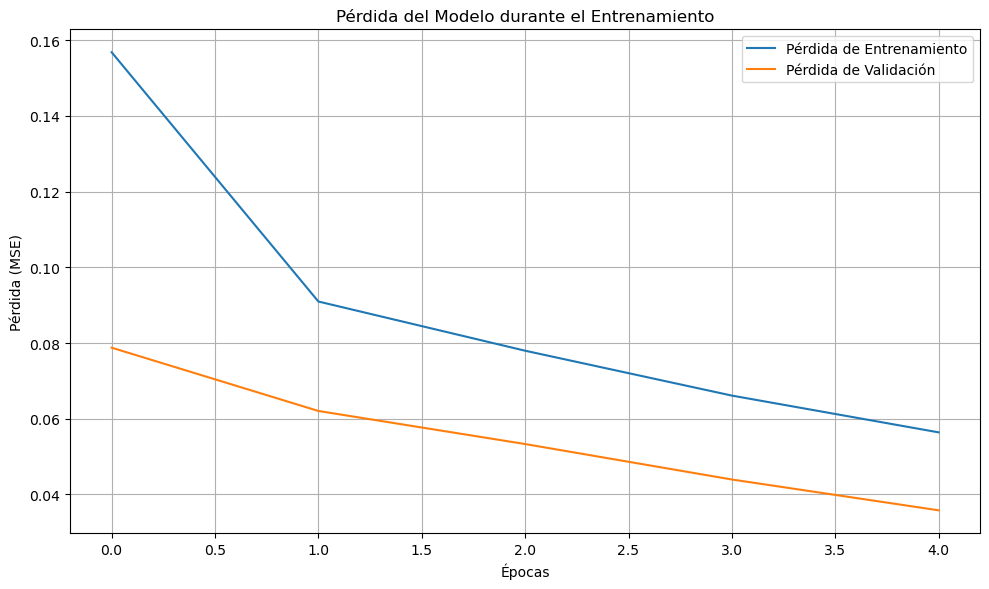

2/2 [==============================] - 5s 1s/step


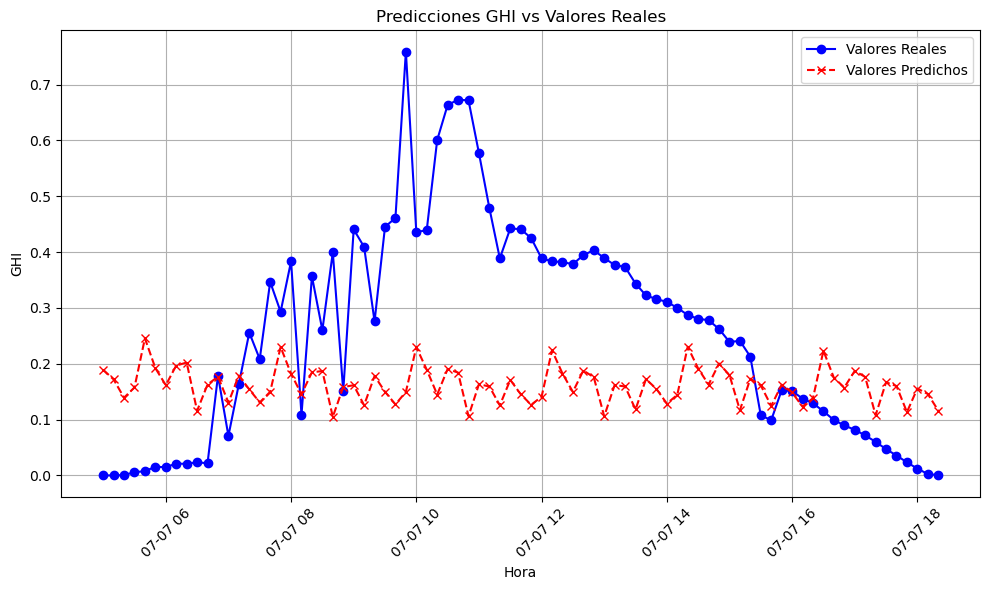

In [3]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# Función para buscar la imagen más cercana en un rango de segundos
def get_closest_image_path(timestamp, image_folder):
    # Crear un patrón de nombre para la imagen con año, mes, día, hora y minuto
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    
    # Buscar archivos en la carpeta que coincidan con el patrón de nombre base
    for second in range(60):  # Revisar segundos de 00 a 59
        image_name = f"{base_image_name}{second:02d}.jpg"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    
    # Retornar None si no se encontró una imagen correspondiente
    return None

# Cargar imágenes y valores GHI normalizados, filtrando las parejas completas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    valid_timestamps = []  # Lista para almacenar los timestamps que tienen tanto imagen como GHI

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path) if image_path else None
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
            valid_timestamps.append(timestamp)  # Añadir el timestamp válido
        else:
            print(f"Imagen no encontrada para timestamp: {timestamp}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler, valid_timestamps
    

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    # Asegurar que las longitudes coinciden entre timestamps y valores de GHI
    min_length = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))

    # Recortar a la longitud mínima para evitar errores de dimensionamiento
    timestamps = timestamps[:min_length]
    y_real = y_real.flatten()[:min_length]
    y_pred = y_pred.flatten()[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_real, label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps, y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')
    
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60
    data_points = int(delta_minutes // data_frequency_minutes)
    seq_len = max(min_seq_len, data_points // 3)
    num_pred = max(min_num_pred, data_points // 6)
    return seq_len, num_pred

# Entrenamiento del modelo modificado para secuencias usando VGG16
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    vgg16_base.trainable = False

    image_input = Input(shape=(seq_len, 64, 64, 3))
    vgg16_features = TimeDistributed(vgg16_base)(image_input)
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    lstm_out = LSTM(64, return_sequences=False)(concat)
    lstm_out = Dropout(0.3)(lstm_out)
    output = Dense(num_pred)(lstm_out)

    model = Model([image_input, numeric_input], output)
    model.compile(optimizer='adam', loss='mse')

    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=5, batch_size=32)

    return model, history

# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Definir rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-07-01 05:00:00'
fecha_fin_entrenamiento = '2023-07-06 18:20:00'
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI con el filtro de parejas válidas
image_folder = 'Images/ACMF_test'
X_images_train, y_ghi_train, scaler_train, valid_timestamps_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Definir rango de fechas para la predicción
fecha_inicio_prediccion = '2023-07-07 05:00:00'
fecha_fin_prediccion = '2023-07-07 18:20:00'
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]
X_images_test, y_ghi_test, scaler_test, valid_timestamps_test = load_images_and_ghi(df_prediccion, image_folder)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

if len(X_images_train) > seq_len:
    # Entrenar el modelo con los datos de entrenamiento
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    # Función para graficar el desempeño del modelo
    def plot_training_history(history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida de Validación')
        plt.title("Pérdida del Modelo durante el Entrenamiento")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Graficar el desempeño del modelo
    plot_training_history(history)

    # Verificar si hay suficientes datos para crear secuencias de predicción
    if len(X_images_test) > seq_len:
        # Crear secuencias de entrada y salida con las nuevas imágenes y valores GHI
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            # Hacer predicciones con el modelo en las nuevas secuencias
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])

            # Invertir la normalización de los valores predichos y reales
            y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
            y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1))

            # Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
            timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')

            # Graficar los resultados predichos y reales para las nuevas fechas
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")
        else:
            print("No hay suficientes secuencias para generar predicciones.")
else:
    print("No hay suficientes imágenes en el rango de fechas seleccionado para el entrenamiento.")

Epoch 1/30
23/23 [==============================] - 54s 2s/step - loss: 7.8566 - val_loss: 7.1580
Epoch 2/30
23/23 [==============================] - 52s 2s/step - loss: 6.7549 - val_loss: 6.2358
Epoch 3/30
23/23 [==============================] - 52s 2s/step - loss: 5.8708 - val_loss: 5.4064
Epoch 4/30
23/23 [==============================] - 52s 2s/step - loss: 5.0781 - val_loss: 4.6594
Epoch 5/30
23/23 [==============================] - 52s 2s/step - loss: 4.3589 - val_loss: 3.9912
Epoch 6/30
23/23 [==============================] - 52s 2s/step - loss: 3.7225 - val_loss: 3.3958
Epoch 7/30
23/23 [==============================] - 52s 2s/step - loss: 3.1593 - val_loss: 2.8634
Epoch 8/30
23/23 [==============================] - 52s 2s/step - loss: 2.6619 - val_loss: 2.4016
Epoch 9/30
23/23 [==============================] - 58s 3s/step - loss: 2.2298 - val_loss: 2.0072
Epoch 10/30
23/23 [==============================] - 54s 2s/step - loss: 1.8587 - val_loss: 1.6634
Epoch 11/30
23/23 [

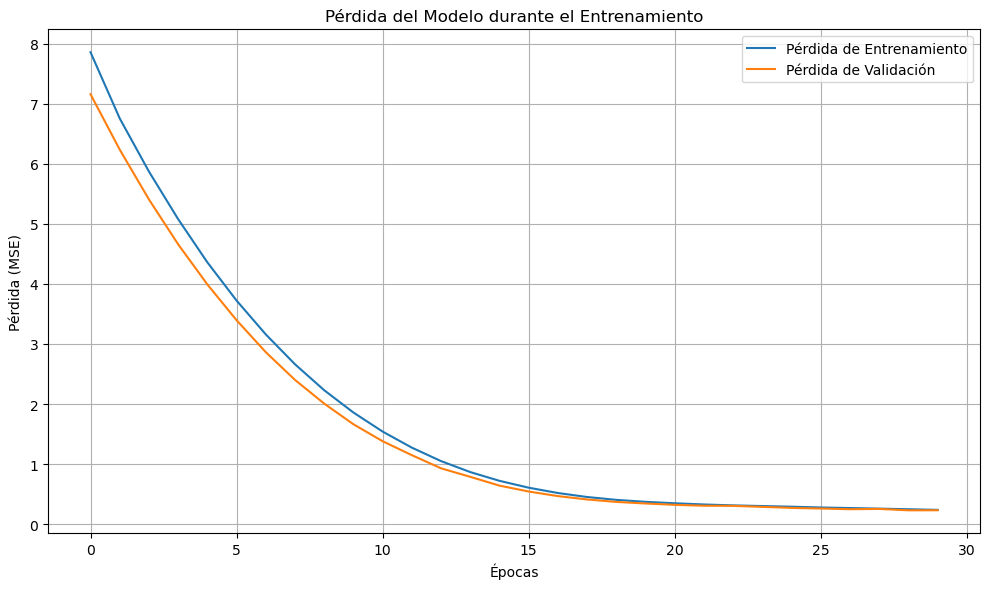

2/2 [==============================] - 11s 1s/step


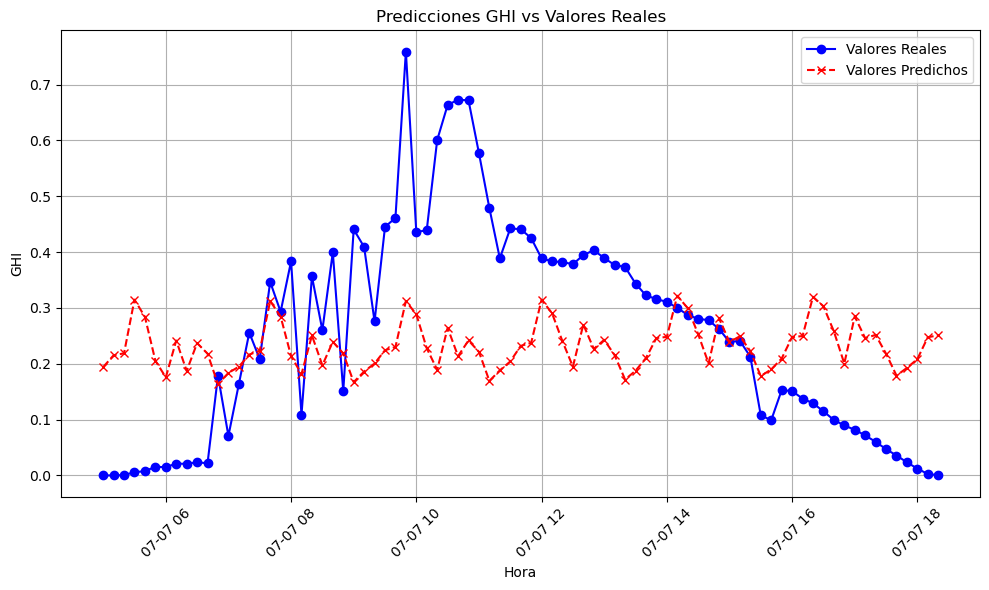

In [ ]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers.legacy import RMSprop  # Importar la versión heredada
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# Función para buscar la imagen más cercana en un rango de segundos
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.jpg"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

# Cargar imágenes y valores GHI normalizados, filtrando las parejas completas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    valid_timestamps = []

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path) if image_path else None
        
        if img is not None:
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
            valid_timestamps.append(timestamp)
        else:
            print(f"Imagen no encontrada para timestamp: {timestamp}")
    
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler, valid_timestamps

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])
        X_seq_ghi.append(y_ghi[i:i+seq_len])
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    min_length = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))
    timestamps = timestamps[:min_length]
    y_real = y_real.flatten()[:min_length]
    y_pred = y_pred.flatten()[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_real, label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps, y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60
    data_points = int(delta_minutes // data_frequency_minutes)
    seq_len = max(min_seq_len, data_points // 3)
    num_pred = max(min_num_pred, data_points // 6)
    return seq_len, num_pred

# Entrenamiento del modelo modificado para secuencias usando VGG16 y LSTM
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    vgg16_base.trainable = False

    image_input = Input(shape=(seq_len, 64, 64, 3))
    vgg16_features = TimeDistributed(vgg16_base)(image_input)
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    lstm_out = LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))(concat)
    lstm_out = Dropout(0.3)(lstm_out)
    output = Dense(num_pred, kernel_regularizer=l2(0.01))(lstm_out)

    model = Model([image_input, numeric_input], output)
    model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse')

    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=30, batch_size=16)

    return model, history

# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Definir rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-07-01 05:00:00'
fecha_fin_entrenamiento = '2023-07-06 18:20:00'
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI con el filtro de parejas válidas
image_folder = 'Images/ACMF_test'
X_images_train, y_ghi_train, scaler_train, valid_timestamps_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Definir rango de fechas para la predicción
fecha_inicio_prediccion = '2023-07-07 05:00:00'
fecha_fin_prediccion = '2023-07-07 18:20:00'
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]
X_images_test, y_ghi_test, scaler_test, valid_timestamps_test = load_images_and_ghi(df_prediccion, image_folder)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

if len(X_images_train) > seq_len:
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    def plot_training_history(history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida de Validación')
        plt.title("Pérdida del Modelo durante el Entrenamiento")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_training_history(history)

    if len(X_images_test) > seq_len:
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])
            y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
            y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1))

            timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")
        else:
            print("No hay suficientes secuencias para generar predicciones.")
else:
    print("No hay suficientes imágenes en el rango de fechas seleccionado para el entrenamiento.")


In [15]:
# Desnormalizar los valores predichos
y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
y_ghi_pred_test_inversed

array([[0.1939921 , 0.21515651, 0.21870993, 0.3148027 , 0.2841003 ,
        0.20564055, 0.1756029 , 0.2416017 , 0.18715295, 0.23700242,
        0.21803898, 0.16347948, 0.18362758],
       [0.19479074, 0.21646295, 0.22326483, 0.31225413, 0.28459257,
        0.21399198, 0.18141423, 0.25065804, 0.19722901, 0.23939231,
        0.218478  , 0.16714744, 0.18605608],
       [0.20047496, 0.2242447 , 0.2299782 , 0.31225657, 0.2884637 ,
        0.22774835, 0.18908623, 0.26426885, 0.213642  , 0.2417396 ,
        0.22131468, 0.16929592, 0.18813449],
       [0.20405358, 0.23194844, 0.23745291, 0.3146851 , 0.29058573,
        0.24030207, 0.19486922, 0.27023867, 0.22660653, 0.24287178,
        0.21531144, 0.17175385, 0.18744105],
       [0.21018873, 0.24607788, 0.24806885, 0.3217854 , 0.29952228,
        0.2530058 , 0.2006455 , 0.2815412 , 0.23885702, 0.24929482,
        0.22259763, 0.17799039, 0.18992884],
       [0.20933232, 0.24778606, 0.24958181, 0.31986213, 0.30290928,
        0.2580948 , 0.20034

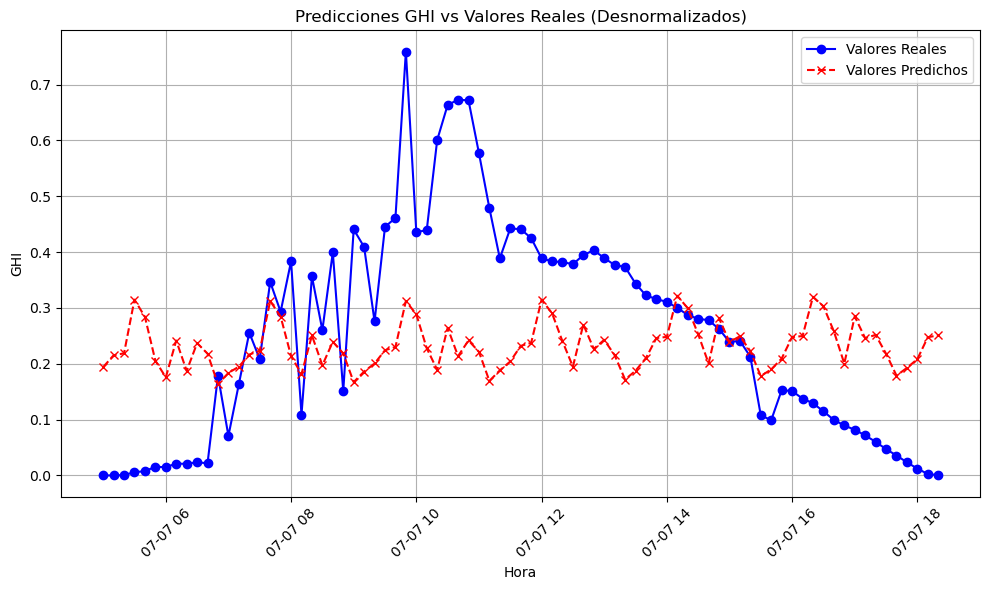

In [16]:
# Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')

# Función para graficar los datos reales y predichos desnormalizados
def plot_real_vs_predicted_desnormalized(timestamps, y_real, y_pred, title="Predicciones GHI vs Valores Reales (Desnormalizados)"):
    # Asegurar que las longitudes coinciden entre timestamps y valores de GHI
    min_length = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))

    # Recortar a la longitud mínima para evitar errores de dimensionamiento
    timestamps = timestamps[:min_length]
    y_real = y_real.flatten()[:min_length]
    y_pred = y_pred.flatten()[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_real, label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps, y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')
    
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Llamar a la función de graficación con los valores desnormalizados
plot_real_vs_predicted_desnormalized(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales (Desnormalizados)")


In [18]:
# Asegúrate de que y_ghi_pred_test está en el formato correcto antes de la desnormalización
y_ghi_pred_test_flattened = y_ghi_pred_test.flatten().reshape(-1, 1)  # Asegura que sea una matriz 2D

# Desnormalizar los valores predichos y reales
y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test_flattened).reshape(-1, num_pred)
y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1)).flatten()


In [19]:
print("Mínimo del escalador:", scaler_test.data_min_)
print("Máximo del escalador:", scaler_test.data_max_)

Mínimo del escalador: [9.84615385e-06]
Máximo del escalador: [0.75911685]


/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/5
23/23 [==============================] - 59s 3s/step - loss: 0.1458 - val_loss: 0.0602
Epoch 2/5
23/23 [==============================] - 57s 3s/step - loss: 0.0788 - val_loss: 0.0493
Epoch 3/5
23/23 [==============================] - 57s 3s/step - loss: 0.0643 - val_loss: 0.0447
Epoch 4/5
23/23 [==============================] - 57s 3s/step - loss: 0.0583 - val_loss: 0.0385
Epoch 5/5
23/23 [==============================] - 57s 3s/step - loss: 0.0546 - val_loss: 0.0335


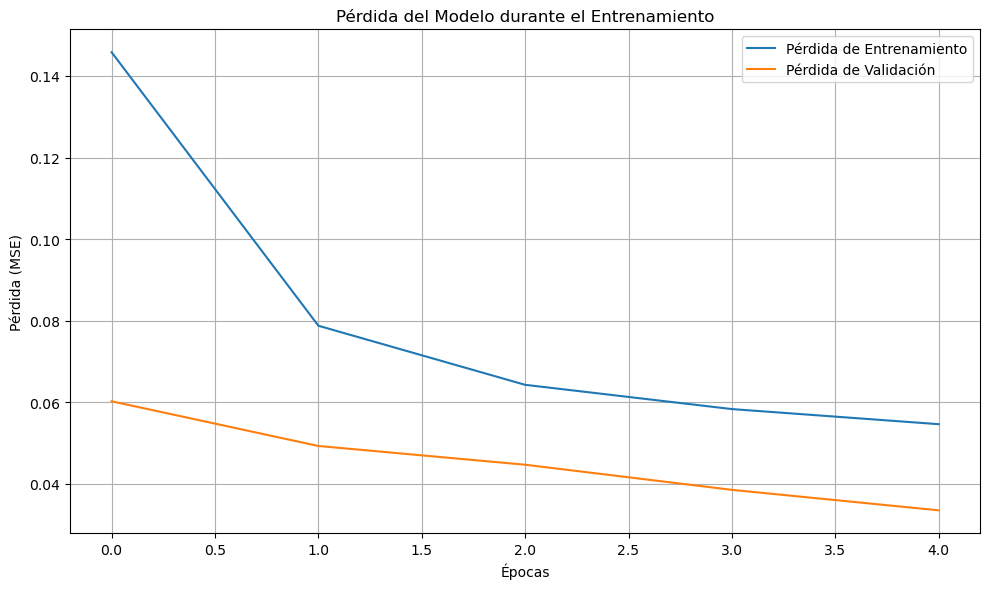

2/2 [==============================] - 6s 1s/step


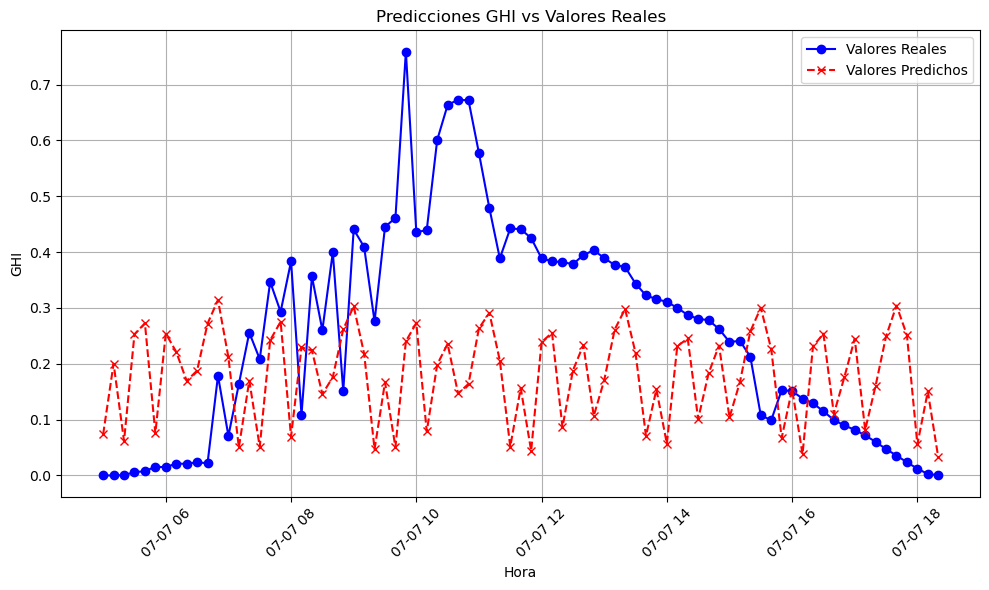

In [20]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import EarlyStopping

# Función para buscar la imagen más cercana en un rango de segundos
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):  # Revisar segundos de 00 a 59
        image_name = f"{base_image_name}{second:02d}.jpg"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

# Cargar imágenes y valores GHI normalizados, filtrando las parejas completas
def load_images_and_ghi(df_filtrado, image_folder, scaler=None):
    images = []
    ghi_values = []
    valid_timestamps = []

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path) if image_path else None
        
        if img is not None:
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
            valid_timestamps.append(timestamp)
        else:
            print(f"Imagen no encontrada para timestamp: {timestamp}")

    ghi_values = np.array(ghi_values).reshape(-1, 1)
    
    # Ajustar el escalador si no ha sido ajustado previamente
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(ghi_values)  # Ajuste del escalador en los valores originales

    ghi_values_scaled = scaler.transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler, valid_timestamps

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])
        X_seq_ghi.append(y_ghi[i:i+seq_len])
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    min_length = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))
    timestamps = timestamps[:min_length]
    y_real = y_real.flatten()[:min_length]
    y_pred = y_pred.flatten()[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_real, label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps, y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60
    data_points = int(delta_minutes // data_frequency_minutes)
    seq_len = max(min_seq_len, data_points // 3)
    num_pred = max(min_num_pred, data_points // 6)
    return seq_len, num_pred

# Entrenamiento del modelo modificado para secuencias usando VGG16
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    vgg16_base.trainable = False

    image_input = Input(shape=(seq_len, 64, 64, 3))
    vgg16_features = TimeDistributed(vgg16_base)(image_input)
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    lstm_out = LSTM(64, return_sequences=False)(concat)
    lstm_out = Dropout(0.3)(lstm_out)
    output = Dense(num_pred)(lstm_out)

    model = Model([image_input, numeric_input], output)
    model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse')

    # Early stopping para evitar sobreentrenamiento
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=5, batch_size=16, callbacks=[early_stopping])

    return model, history

# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Ajustar el escalador en los datos originales de GHI
scaler = MinMaxScaler()
scaler.fit(df[['GHI']])

# Definir rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-07-01 05:00:00'
fecha_fin_entrenamiento = '2023-07-06 18:20:00'
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI con el filtro de parejas válidas
image_folder = 'Images/ACMF_test'
X_images_train, y_ghi_train, _, valid_timestamps_train = load_images_and_ghi(df_entrenamiento, image_folder, scaler)

# Definir rango de fechas para la predicción
fecha_inicio_prediccion = '2023-07-07 05:00:00'
fecha_fin_prediccion = '2023-07-07 18:20:00'
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]
X_images_test, y_ghi_test, _, valid_timestamps_test = load_images_and_ghi(df_prediccion, image_folder, scaler)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

if len(X_images_train) > seq_len:
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    # Graficar el desempeño del modelo
    def plot_training_history(history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida de Validación')
        plt.title("Pérdida del Modelo durante el Entrenamiento")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_training_history(history)

    if len(X_images_test) > seq_len:
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])

            y_ghi_pred_test_inversed = scaler.inverse_transform(y_ghi_pred_test.flatten().reshape(-1, 1)).reshape(-1, num_pred)
            y_ghi_test_inversed = scaler.inverse_transform(y_ghi_test.flatten().reshape(-1, 1))

            timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")
        else:
            print("No hay suficientes secuencias para generar predicciones.")
else:
    print("No hay suficientes imágenes en el rango de fechas seleccionado para el entrenamiento.")


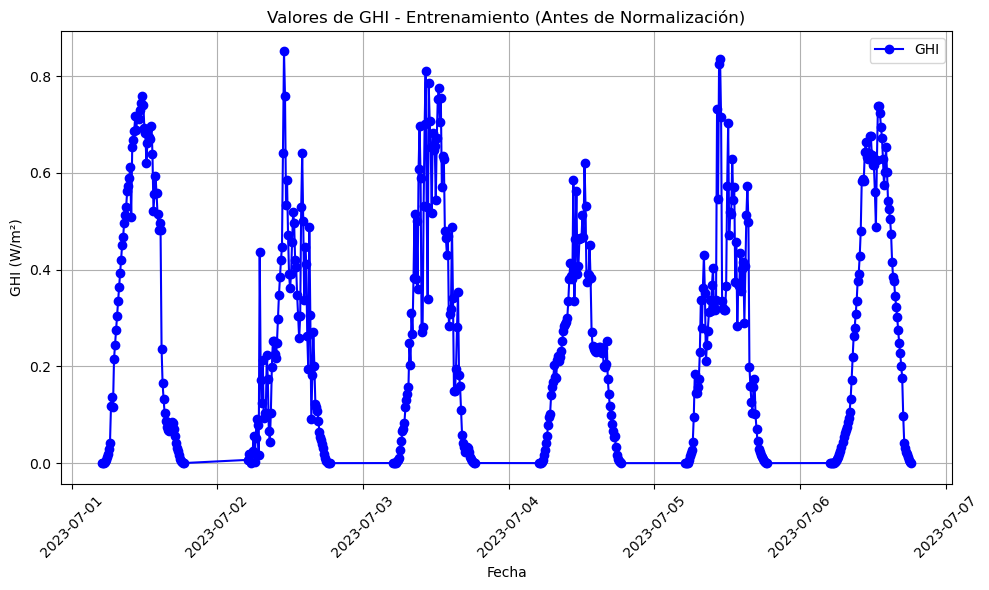

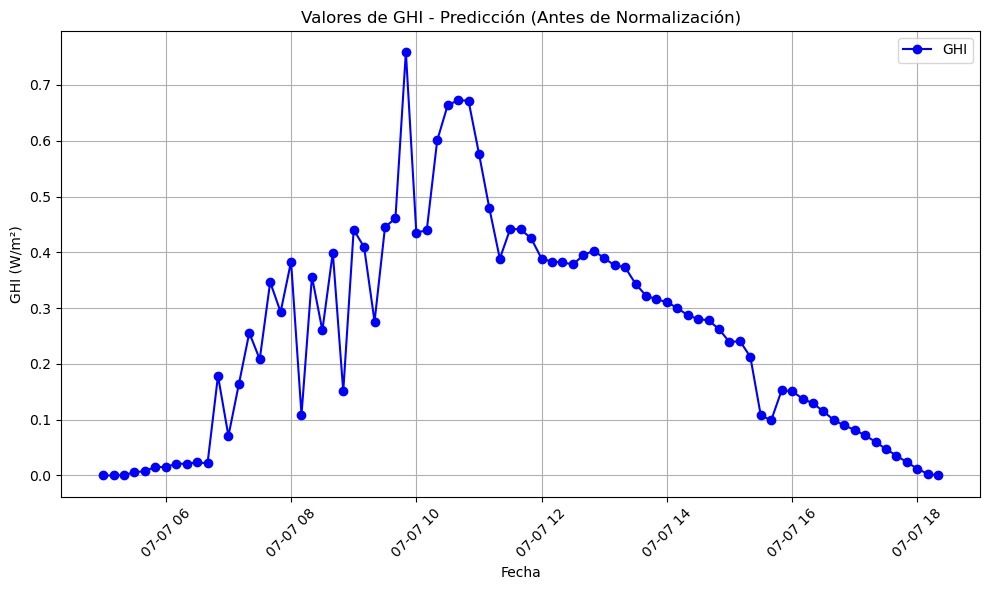

In [21]:
# Graficar los valores de GHI para df_entrenamiento y df_prediccion antes de la normalización

def plot_ghi_values(df, title="Valores de GHI"):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Timestamp'], df['GHI'], label="GHI", color='blue', marker='o')
    plt.title(title)
    plt.xlabel("Fecha")
    plt.ylabel("GHI (W/m²)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Graficar los valores de GHI del entrenamiento
plot_ghi_values(df_entrenamiento, title="Valores de GHI - Entrenamiento (Antes de Normalización)")

# Graficar los valores de GHI de la predicción
plot_ghi_values(df_prediccion, title="Valores de GHI - Predicción (Antes de Normalización)")


Epoch 1/5
23/23 [==============================] - 52s 2s/step - loss: 7.8210 - val_loss: 7.1363
Epoch 2/5
23/23 [==============================] - 51s 2s/step - loss: 6.7305 - val_loss: 6.2130
Epoch 3/5
23/23 [==============================] - 50s 2s/step - loss: 5.8456 - val_loss: 5.3942
Epoch 4/5
23/23 [==============================] - 49s 2s/step - loss: 5.0557 - val_loss: 4.6434
Epoch 5/5
23/23 [==============================] - 50s 2s/step - loss: 4.3439 - val_loss: 3.9795


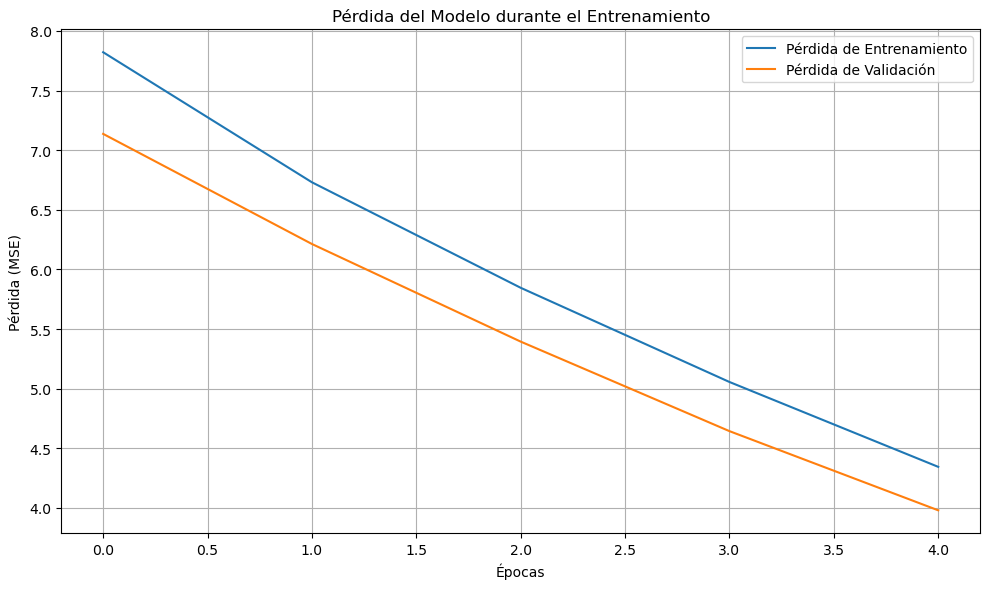

2/2 [==============================] - 5s 1s/step


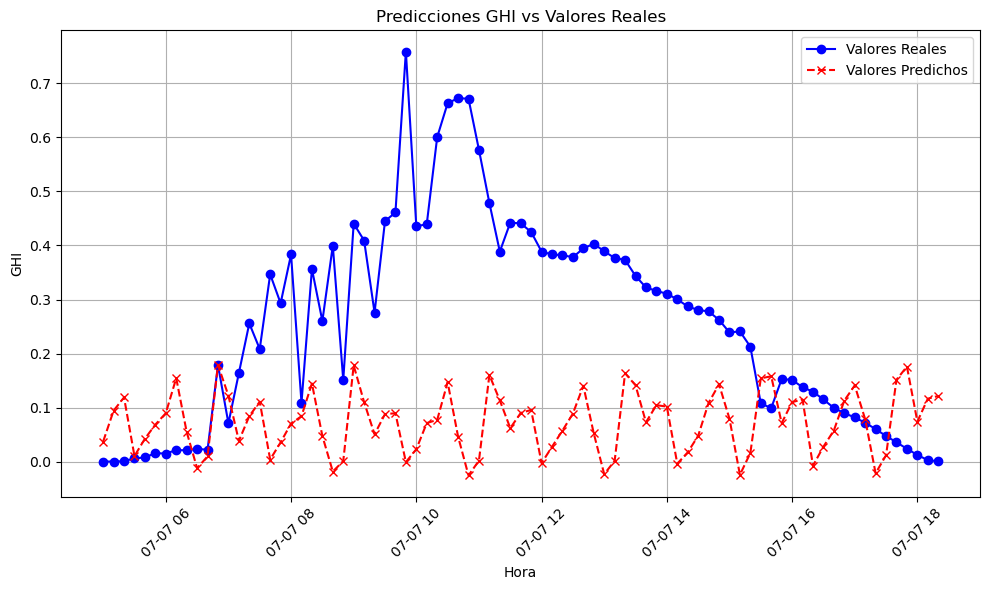

ValueError: All arrays must be of the same length

In [25]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime, time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers.legacy import RMSprop  # Importar la versión heredada
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# Función para buscar la imagen más cercana en un rango de segundos
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.jpg"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

# Cargar imágenes y valores GHI normalizados, filtrando las parejas completas
def load_images_and_ghi(df_filtrado, image_folder, scaler=None):
    images = []
    ghi_values = []
    valid_timestamps = []
    temp_ambient = []

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        temp_amb_value = row['TempAmb']
        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path) if image_path else None
        
        if img is not None:
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
            valid_timestamps.append(timestamp)
            temp_ambient.append(temp_amb_value)
        else:
            print(f"Imagen no encontrada para timestamp: {timestamp}")
    
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    if scaler is None:
        scaler = MinMaxScaler()
        ghi_values_scaled = scaler.fit_transform(ghi_values)
    else:
        ghi_values_scaled = scaler.transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler, valid_timestamps, temp_ambient

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])
        X_seq_ghi.append(y_ghi[i:i+seq_len])
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    min_length = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))
    timestamps = timestamps[:min_length]
    y_real = y_real.flatten()[:min_length]
    y_pred = y_pred.flatten()[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_real, label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps, y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60
    data_points = int(delta_minutes // data_frequency_minutes)
    seq_len = max(min_seq_len, data_points // 3)
    num_pred = max(min_num_pred, data_points // 6)
    return seq_len, num_pred

# Entrenamiento del modelo modificado para secuencias usando VGG16 y LSTM
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    vgg16_base.trainable = False

    image_input = Input(shape=(seq_len, 64, 64, 3))
    vgg16_features = TimeDistributed(vgg16_base)(image_input)
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    lstm_out = LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))(concat)
    lstm_out = Dropout(0.3)(lstm_out)
    output = Dense(num_pred, kernel_regularizer=l2(0.01))(lstm_out)

    model = Model([image_input, numeric_input], output)
    model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=5, batch_size=16, callbacks=[early_stopping])

    return model, history

# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Definir rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-07-01 05:00:00'
fecha_fin_entrenamiento = '2023-07-06 18:20:00'
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI con el filtro de parejas válidas
image_folder = 'Images/ACMF_test'
X_images_train, y_ghi_train, scaler_train, valid_timestamps_train, temp_ambient_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Definir rango de fechas para la predicción
fecha_inicio_prediccion = '2023-07-07 05:00:00'
fecha_fin_prediccion = '2023-07-07 18:20:00'
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]
X_images_test, y_ghi_test, scaler_test, valid_timestamps_test, temp_ambient_test = load_images_and_ghi(df_prediccion, image_folder, scaler_train)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

if len(X_images_train) > seq_len:
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    def plot_training_history(history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida de Validación')
        plt.title("Pérdida del Modelo durante el Entrenamiento")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_training_history(history)

    # Verificar si hay suficientes datos para crear secuencias de predicción
    if len(X_images_test) > seq_len:
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            # Hacer predicciones con el modelo en las nuevas secuencias
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])

            # Desnormalizar los valores predichos y reales
            y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
            y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1))

            # Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
            timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')

            # Graficar los resultados predichos y reales para las nuevas fechas
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")

            # Crear DataFrame para los resultados predichos con los Timestamps y TempAmb de prueba
            pred_results_df = pd.DataFrame({
                'timestamp': valid_timestamps_test[-len(y_ghi_pred_test_inversed):],
                'ghi': y_ghi_pred_test_inversed.flatten(),
                'temp_ambient': temp_ambient_test[-len(y_ghi_pred_test_inversed):]
            })

            # Guardar el DataFrame de resultados en un archivo CSV
            pred_results_df.to_csv('predicciones_GHI_tempAmb.csv', index=False)
            print("Predicciones guardadas en 'predicciones_GHI_tempAmb.csv'")
        else:
            print("No hay suficientes secuencias para generar predicciones.")
else:
    print("No hay suficientes imágenes en el rango de fechas seleccionado para el entrenamiento.")


Epoch 1/5
23/23 [==============================] - 53s 2s/step - loss: 7.8502 - val_loss: 7.1496
Epoch 2/5
23/23 [==============================] - 52s 2s/step - loss: 6.7563 - val_loss: 6.2358
Epoch 3/5
23/23 [==============================] - 52s 2s/step - loss: 5.8635 - val_loss: 5.4102
Epoch 4/5
23/23 [==============================] - 50s 2s/step - loss: 5.0766 - val_loss: 4.6638
Epoch 5/5
23/23 [==============================] - 49s 2s/step - loss: 4.3604 - val_loss: 3.9884


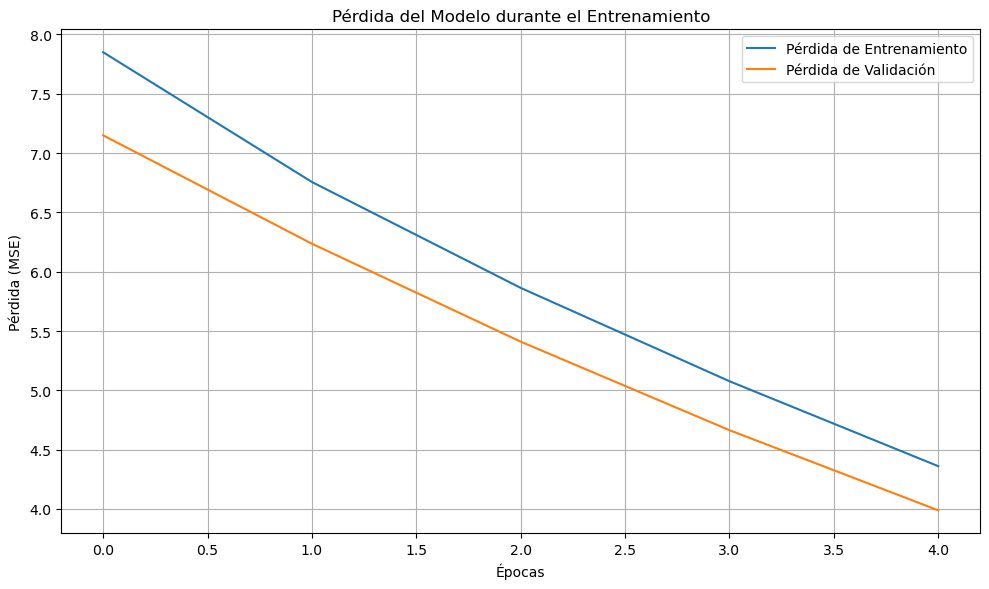

2/2 [==============================] - 5s 1s/step


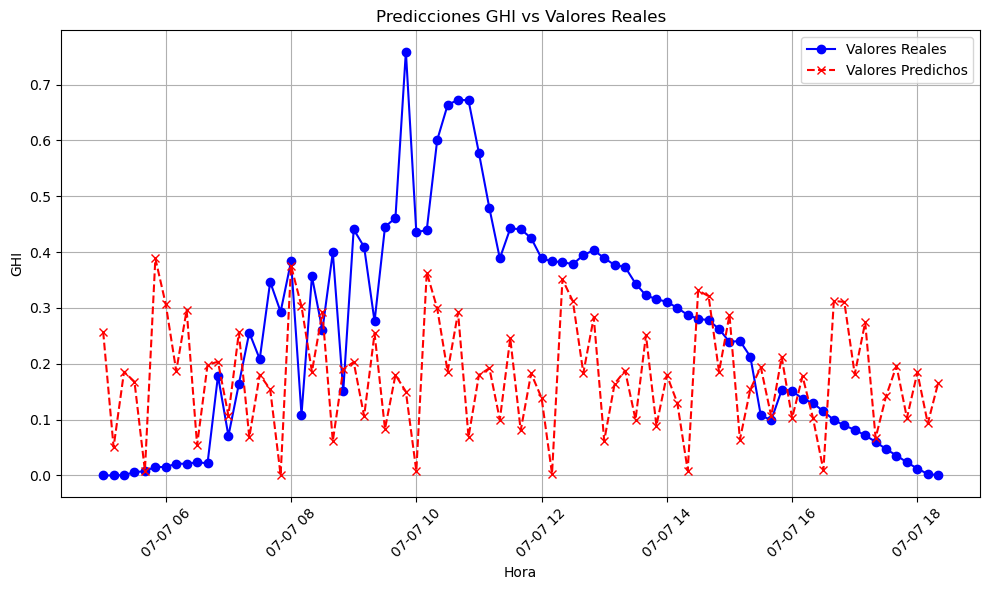

Predicciones guardadas en 'predicciones_GHI_tempAmb.csv'


In [26]:
if len(X_images_train) > seq_len:
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    def plot_training_history(history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida de Validación')
        plt.title("Pérdida del Modelo durante el Entrenamiento")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_training_history(history)

    if len(X_images_test) > seq_len:
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])
            y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
            y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1))

            timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")

            # Asegurar que todas las listas tengan la misma longitud
            min_length = min(len(valid_timestamps_test), len(y_ghi_pred_test_inversed.flatten()), len(temp_ambient_test))

            # Crear DataFrame para los resultados predichos con los Timestamps y TempAmb de prueba
            pred_results_df = pd.DataFrame({
                'timestamp': valid_timestamps_test[-min_length:],
                'ghi': y_ghi_pred_test_inversed.flatten()[-min_length:],
                'temp_air': temp_ambient_test[-min_length:]
            })

            # Guardar el DataFrame de resultados en un archivo CSV
            pred_results_df.to_csv('predicciones_GHI_tempAmb.csv', index=False)
            print("Predicciones guardadas en 'predicciones_GHI_tempAmb.csv'")
        else:
            print("No hay suficientes secuencias para generar predicciones.")
else:
    print("No hay suficientes imágenes en el rango de fechas seleccionado para el entrenamiento.")


Epoch 1/50
23/23 [==============================] - 59s 3s/step - loss: 0.1724 - val_loss: 0.0649
Epoch 2/50
23/23 [==============================] - 58s 3s/step - loss: 0.0939 - val_loss: 0.0559
Epoch 3/50
23/23 [==============================] - 57s 3s/step - loss: 0.0802 - val_loss: 0.0511
Epoch 4/50
23/23 [==============================] - 57s 2s/step - loss: 0.0678 - val_loss: 0.0390
Epoch 5/50
23/23 [==============================] - 57s 2s/step - loss: 0.0600 - val_loss: 0.0369
Epoch 6/50
23/23 [==============================] - 57s 2s/step - loss: 0.0500 - val_loss: 0.0266
Epoch 7/50
23/23 [==============================] - 57s 3s/step - loss: 0.0481 - val_loss: 0.0273
Epoch 8/50
23/23 [==============================] - 57s 3s/step - loss: 0.0413 - val_loss: 0.0219
Epoch 9/50
23/23 [==============================] - 58s 3s/step - loss: 0.0388 - val_loss: 0.0242
Epoch 10/50
23/23 [==============================] - 57s 2s/step - loss: 0.0360 - val_loss: 0.0178
Epoch 11/50
23/23 [

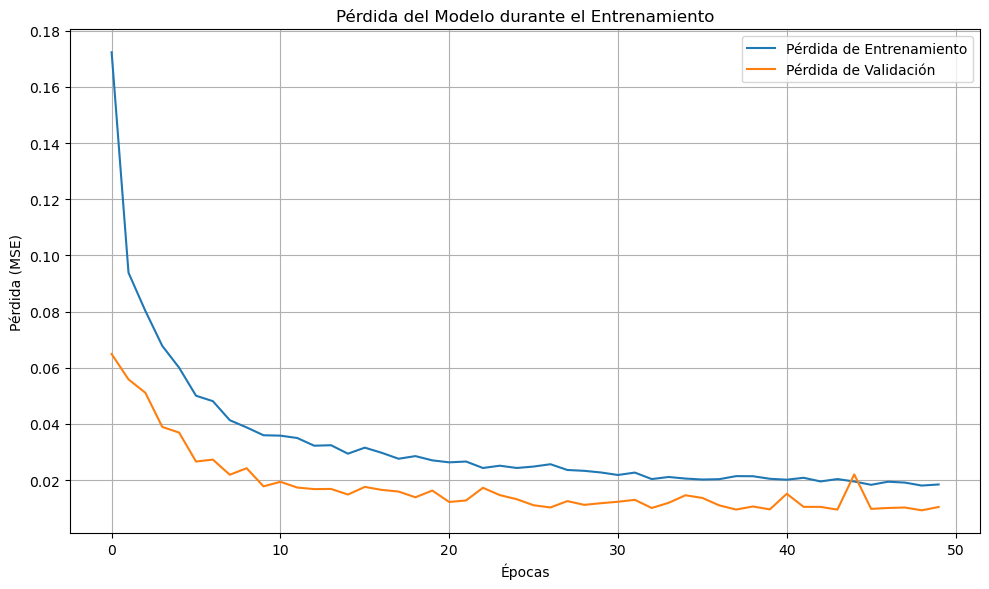

2/2 [==============================] - 6s 1s/step


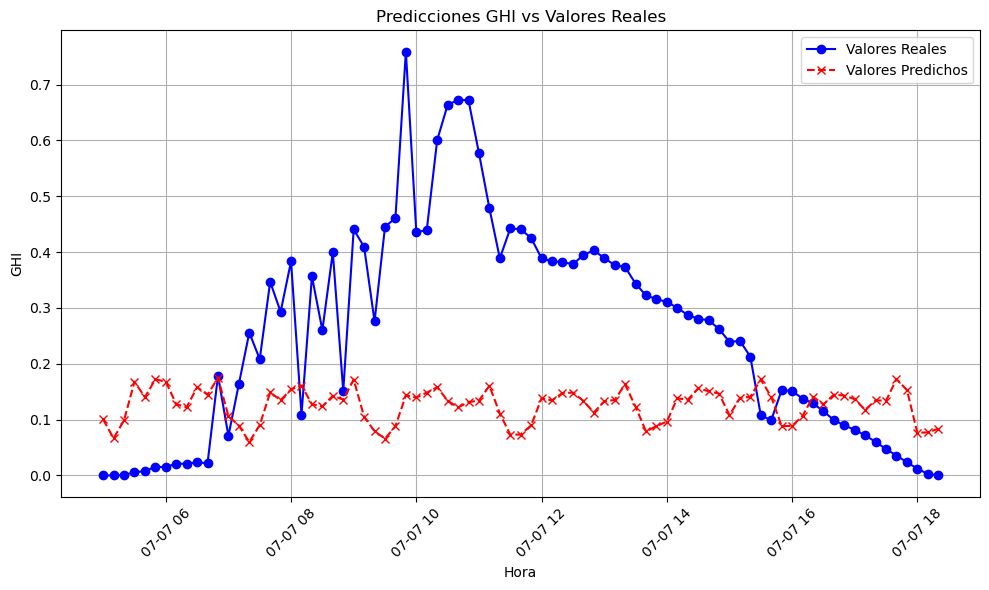

ValueError: All arrays must be of the same length

In [31]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# Función para buscar la imagen más cercana en un rango de segundos
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.jpg"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

# Cargar imágenes y valores GHI normalizados, filtrando las parejas completas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    temp_ambient = []  # Almacena TempAmb para los registros válidos
    valid_timestamps = []

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        temp_value = row['TempAmb']  # Obtener TempAmb
        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path) if image_path else None
        
        if img is not None:
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
            temp_ambient.append(temp_value)
            valid_timestamps.append(timestamp)
        else:
            print(f"Imagen no encontrada para timestamp: {timestamp}")
    
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler, valid_timestamps, temp_ambient

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])
        X_seq_ghi.append(y_ghi[i:i+seq_len])
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    min_length = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))
    timestamps = timestamps[:min_length]
    y_real = y_real.flatten()[:min_length]
    y_pred = y_pred.flatten()[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_real, label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps, y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60
    data_points = int(delta_minutes // data_frequency_minutes)
    seq_len = max(min_seq_len, data_points // 3)
    num_pred = max(min_num_pred, data_points // 6)
    return seq_len, num_pred

# Entrenamiento del modelo modificado para secuencias usando VGG16 y LSTM
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    vgg16_base.trainable = False

    image_input = Input(shape=(seq_len, 64, 64, 3))
    vgg16_features = TimeDistributed(vgg16_base)(image_input)
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    lstm_out = LSTM(64, return_sequences=False)(concat)
    lstm_out = Dropout(0.3)(lstm_out)
    output = Dense(num_pred)(lstm_out)

    model = Model([image_input, numeric_input], output)
    model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse')

    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=50, batch_size=16)

    return model, history

# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Definir rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-07-01 05:00:00'
fecha_fin_entrenamiento = '2023-07-06 18:20:00'
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI con el filtro de parejas válidas
image_folder = 'Images/ACMF_test'
X_images_train, y_ghi_train, scaler_train, valid_timestamps_train, temp_ambient_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Definir rango de fechas para la predicción
fecha_inicio_prediccion = '2023-07-07 05:00:00'
fecha_fin_prediccion = '2023-07-07 18:20:00'
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]
X_images_test, y_ghi_test, scaler_test, valid_timestamps_test, temp_ambient_test = load_images_and_ghi(df_prediccion, image_folder)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

if len(X_images_train) > seq_len:
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    def plot_training_history(history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida de Validación')
        plt.title("Pérdida del Modelo durante el Entrenamiento")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_training_history(history)

    if len(X_images_test) > seq_len:
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            # Hacer predicciones con el modelo en las nuevas secuencias
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])

            # Desnormalizar los valores predichos y reales
            y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
            y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1))

            # Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
            timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")

            # Crear DataFrame para los resultados predichos con los Timestamps y TempAmb de prueba
            pred_results_df = pd.DataFrame({
                'timestamp': valid_timestamps_test[-len(y_ghi_pred_test_inversed):],
                'ghi': y_ghi_pred_test_inversed.flatten(),
                'temp_air': temp_ambient_test[-len(y_ghi_pred_test_inversed):]
            })

            # Guardar el DataFrame de resultados en un archivo CSV
            pred_results_df.to_csv('predicciones_GHI_tempAmb.csv', index=False)
        else:
            print("No hay suficientes secuencias para generar predicciones.")
else:
    print("No hay suficientes imágenes en el rango de fechas seleccionado para el entrenamiento.")

    